# Could Quotebank's data predict the genre and the rating of a movie ? 

Regarding the memorability of a movies, and the gender of the contributors (actors, directors, producers, writers).

In [8]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import euclidean_distances, r2_score
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

In [121]:
df_ML = pd.read_pickle('../generated/QUOTEBANK/memorability.pickle')
df_ML.reset_index(inplace = True)
df_ML.head(5)

,index,id_film,film,quoteID,gender_speaker_pct,days_mean,days_mean_norm,days_max,nb_quote_month,days_mean_before,days_mean_norm_before,days_max_before,nb_quote_month_before,days_max_norm,nb_quote_month_norm,days_max_norm_before,nb_quote_month_norm_before,nb_quoteID_norm,memorability
0,0,tt0002833,Evinrude,9,0.888889,38160.666667,0.976476,38273.0,0,NaN,NaN,NaN,0,0.979350,0.0,NaN,0.0,0.007519,0.490836
1,1,tt0003631,Aristocracy,7,0.571429,38188.571429,0.977190,38328.0,0,NaN,NaN,NaN,0,0.980757,0.0,NaN,0.0,0.005639,0.490897
2,2,tt0004134,Hypocrites,3,1.000000,37790.333333,0.966999,37970.0,0,NaN,NaN,NaN,0,0.971597,0.0,NaN,0.0,0.001880,0.485119
3,3,tt0004963,Beulah,16,0.875000,37763.375000,0.966309,37972.0,0,NaN,NaN,NaN,0,0.971648,0.0,NaN,0.0,0.014098,0.488014
4,4,tt0005190,Destruction,111,0.855856,37804.675676,0.967366,37984.0,0,NaN,NaN,NaN,0,0.971955,0.0,NaN,0.0,0.103383,0.510676


## Task 1 
Load quotebank dataset previously filtered and completed (question_2). Then add ratings and number of voting columns into the dataframe thanks to IMDb. 

In [122]:
IMDb_final = pd.read_pickle('../generated/IMDb/IMDb_final.pickle')

In [123]:
gender_movie_pct = []
for row in IMDb_final['gender_pct'] :
    if row == None : 
        gender_movie_pct.append(np.NaN) 
    else : 
        gender_movie_pct.append(float(row['male'])) 
IMDb_final['gender_movie_pct'] = gender_movie_pct

In [124]:
IMDb_final.rename(columns={'tconst': 'id_film'}, inplace=True)
IMDb_final.head(2)

,id_film,originalTitle,year,runtimeMinutes,genres,writers,actor/actress,crew,averageRating,numVotes,gender_pct,gender_movie_pct
228,tt0002833,Evinrude,1914.0,NaN,"Crime,Drama",[nm0263912],"{'nm1892090': {'name': 'Olly Klein', 'role': [...","{'nm0753233': {'name': 'Stellan Rye', 'role': ...",NaN,NaN,"{'male': 0.75, 'female': 0.25}",0.750000
370,tt0003631,Aristocracy,1914.0,NaN,Drama,[nm0397167],"{'nm0694362': {'name': 'Tyrone Power Sr.', 'ro...","{'nm0373614': {'name': 'Thomas N. Heffron', 'r...",NaN,NaN,"{'male': 0.6666666666666661, 'female': 0.33333...",0.666667


In [125]:
df_Q3_comp = pd.merge(df_ML,IMDb_final[['id_film','gender_movie_pct','averageRating','numVotes']],on='id_film',how='left')
df_Q3_comp

,index,id_film,film,quoteID,gender_speaker_pct,days_mean,days_mean_norm,days_max,nb_quote_month,days_mean_before,...,nb_quote_month_before,days_max_norm,nb_quote_month_norm,days_max_norm_before,nb_quote_month_norm_before,nb_quoteID_norm,memorability,gender_movie_pct,averageRating,numVotes
0,0,tt0002833,Evinrude,9,0.888889,38160.666667,0.976476,38273.0,0,NaN,...,0,0.979350,0.0,NaN,0.0,0.007519,0.490836,0.750000,NaN,NaN
1,1,tt0003631,Aristocracy,7,0.571429,38188.571429,0.977190,38328.0,0,NaN,...,0,0.980757,0.0,NaN,0.0,0.005639,0.490897,0.666667,NaN,NaN
2,2,tt0004134,Hypocrites,3,1.000000,37790.333333,0.966999,37970.0,0,NaN,...,0,0.971597,0.0,NaN,0.0,0.001880,0.485119,0.625000,6.6,589.0
3,3,tt0004963,Beulah,16,0.875000,37763.375000,0.966309,37972.0,0,NaN,...,0,0.971648,0.0,NaN,0.0,0.014098,0.488014,0.714286,NaN,NaN
4,4,tt0005190,Destruction,111,0.855856,37804.675676,0.967366,37984.0,0,NaN,...,0,0.971955,0.0,NaN,0.0,0.103383,0.510676,0.875000,7.4,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6578,6578,tt9894450,Felicità,1,1.000000,NaN,NaN,NaN,0,574.000000,...,0,NaN,0.0,0.312296,0.0,0.000000,NaN,1.000000,6.7,826.0
6579,6579,tt9894470,VFW,146,0.923611,NaN,NaN,NaN,0,594.061644,...,0,NaN,0.0,0.420566,0.0,0.136278,NaN,1.000000,6.1,7467.0
6580,6580,tt9900782,Kaithi,1,1.000000,NaN,NaN,NaN,0,472.000000,...,0,NaN,0.0,0.256801,0.0,0.000000,NaN,1.000000,8.5,18071.0
6581,6581,tt9902160,Herself,15,0.266667,NaN,NaN,NaN,0,537.200000,...,0,NaN,0.0,0.372688,0.0,0.013158,NaN,0.285714,7.0,2823.0


In [126]:
# Eliminating all films that have fewer than 10 votes
df_Q3_comp = df_Q3_comp[df_Q3_comp['numVotes']>10]

## Task 2
Creat good environnement for machine learning : data training set, data validation and testing data.

What are the **features**? 
- gender_speaker_pct : proportion of male (for the speakers)
- gender_movie_pct : proportion of male (for all participants in the creation of the film)
- nb_quoteID_norm : number of quotes occurences
- days_mean_norm_before: average number of days before the release date (standardized)
- days_max_norm_before : number of days from the first day we talk about it until the release (standardized)
- nb_quote_month_norm_before: the number of situations one month before the exit  (standardized)
- days_mean_norm: average number of days after the release date (where it is discussed) (standardized)
- days_max_norm : number of days until the last day that it is discussed (standardized)
- nb_quote_month_norm : the number of situations one month after discharge (standardized)

What is the **response**?
-ratings : determine if the film is a success or a failure

In [127]:
#specify feature for the machine learning
movies_features = ['gender_speaker_pct','gender_movie_pct','nb_quoteID_norm', 'days_mean_norm_before', 'days_max_norm_before', 'nb_quote_month_norm_before', 'days_mean_norm','days_max_norm','nb_quote_month_norm']

In [128]:
#the dataset contains one categorical variable: gender (male|female)
#convert it to a numerical variable in order to have the features vector
X = pd.get_dummies(df_Q3_comp[movies_features])
X.head()

,gender_speaker_pct,gender_movie_pct,nb_quoteID_norm,days_mean_norm_before,days_max_norm_before,nb_quote_month_norm_before,days_mean_norm,days_max_norm,nb_quote_month_norm
2,1.000000,0.625000,0.001880,NaN,NaN,0.0,0.966999,0.971597,0.0
4,0.855856,0.875000,0.103383,NaN,NaN,0.0,0.967366,0.971955,0.0
6,1.000000,0.333333,0.000000,NaN,NaN,0.0,0.956372,0.956372,0.0
10,0.857143,0.714286,0.005639,NaN,NaN,0.0,0.958671,0.962359,0.0
11,0.872549,0.750000,0.095865,NaN,NaN,0.0,0.958565,0.962462,0.0


In [ ]:
df_ML_filtred = df_Q3_comp.copy()
#to make a prediction we must eliminate the missing values
len(df_ML_filtred[df_ML_filtred.isna().any(axis=1)])
#replace nan values with mean 
df_ML_filtred = df_ML_filtred.fillna(df_ML_filtred.mean())
len(df_ML_filtred[df_ML_filtred.isna().any(axis=1)])

In [130]:
#store labels for the training
df_ML_filtred = df_ML_filtred.astype({'averageRating': float})

In [131]:
df_ML_filtred.dtypes

index                           int64
id_film                        object
film                           object
quoteID                         int64
gender_speaker_pct            float64
days_mean                     float64
days_mean_norm                float64
days_max                      float64
nb_quote_month                  int64
days_mean_before              float64
days_mean_norm_before         float64
days_max_before               float64
nb_quote_month_before           int64
days_max_norm                 float64
nb_quote_month_norm           float64
days_max_norm_before          float64
nb_quote_month_norm_before    float64
nb_quoteID_norm               float64
memorability                  float64
gender_movie_pct              float64
averageRating                 float64
numVotes                      float64
dtype: object

## Task 3 
Make machine leaning model.

In [133]:
features_cols = X.columns.tolist()
print(features_cols )

['gender_speaker_pct', 'gender_movie_pct', 'nb_quoteID_norm', 'days_mean_norm_before', 'days_max_norm_before', 'nb_quote_month_norm_before', 'days_mean_norm', 'days_max_norm', 'nb_quote_month_norm']


In [134]:
features_cols = X.columns.tolist()
# Creating the features array and the label array
X_array = numpy_helper(df_ML_filtred,features_cols)
Y_array = numpy_helper(df_ML_filtred, ['averageRating'])
# Splitting the dataset in training and testing subset
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_array,
                                                                            Y_array,
                                                                            test_size = 0.3,
                                                                            train_size = 0.7,
                                                                            random_state = 123)

# Checking that the dimension of subsets are coherent with the parameterw we used
print(f"The size of our splitted dataset is now :")
print(f"{X_train.shape = }")
print(f"{X_test.shape = }")
print(f"{y_train.shape = }")
print(f"{y_test.shape = }")

The size of our splitted dataset is now :
X_train.shape = (4024, 9)
X_test.shape = (1725, 9)
y_train.shape = (4024, 1)
y_test.shape = (1725, 1)


### Task 3
Machine Learning

In [135]:
from sklearn.ensemble import GradientBoostingRegressor

R2 = -0.010949499077970826


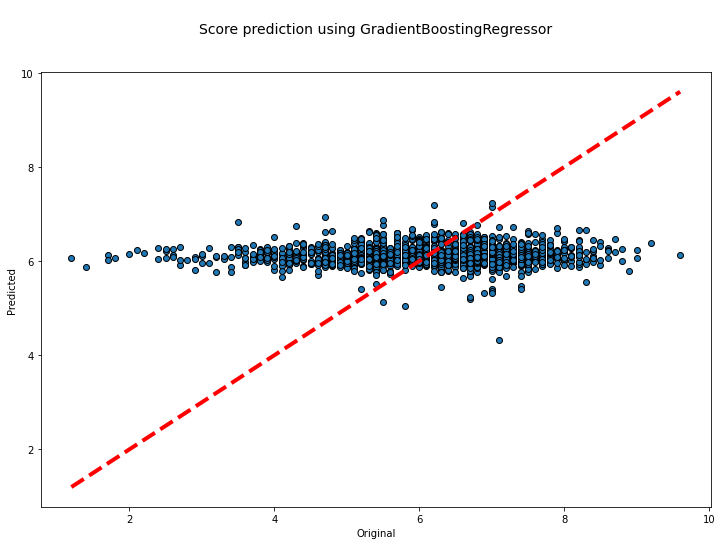

In [139]:
# Training a Gradient Boosting Regressor model
grad_boost_reg = GradientBoostingRegressor()
grad_boost_reg.fit(X_train, np.ravel(y_train))

# Using the model on the test set
y_predicted = grad_boost_reg.predict(X_test)
# Computing R squared metric for the model
print(f"R2 = {r2_score(y_test, y_predicted)}")

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.title('\nScore prediction using GradientBoostingRegressor\n\n', fontsize = 14)
plt.show()


In [137]:
from sklearn.linear_model import LinearRegression

R2 = 0.00785298233721643
lin_reg2.score(X_train, y_train) = 0.010509099021100421
lin_reg2.score(X_test, y_test) = 0.00785298233721643


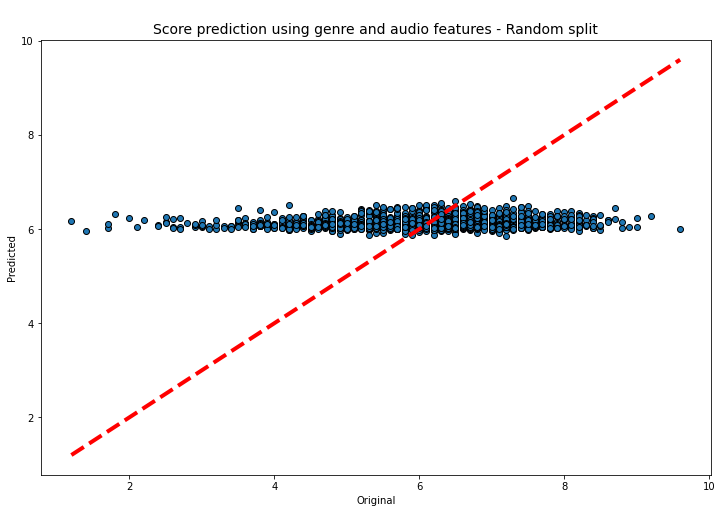

In [138]:
# Creating a linear regression model and training it
lin_reg2 = LinearRegression()
lin_reg2.fit(X_train, y_train)
# Using the model on the test set
y_predicted = lin_reg2.predict(X_test)
# Computing R2 metric for the model
print(f"R2 = {r2_score(y_test, y_predicted)}")
# We see that R2 is still pretty low, although it's almost 3 times bigger than with the previous model

# Computing score for training and test sets (one of the line does the same thing than R2)
print(f"{lin_reg2.score(X_train, y_train) = }")
print(f"{lin_reg2.score(X_test, y_test) = }")

# Plotting the results for test set
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.title('\nScore prediction using genre and audio features - Random split', fontsize = 14)
plt.show()